# Imports

In [3]:
#science imports
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy import stats

#standard library imports
import copy
import glob
import os
import os.path as path
import time

# Set path label for file reading
This is the YYYYMMDD_CVD_XXXX label at the beginning of the XRF map folder.

In [4]:
#this just allows easy folder selection so you don't have to copy the name from the file browser

folders = glob.glob("*_map")
for i in range(0, len(folders)):
    print("{0:>2d} - {1:s} - {2}".format(i, folders[i], len(glob.glob(folders[i]+"/*.spx"))))

 0 - 20230531_CVD_3076_map - 200
 1 - 20230531_CVD_3158_map - 200
 2 - 20230606_CVD_2555_map - 200
 3 - 20230607_CVD_2546_map - 200
 4 - 20230607_CVD_2802_map - 200
 5 - 20230613_CVD_2808_map - 200
 6 - 20230613_CVD_3496_map - 200
 7 - 20230621_CVD_2808_map - 800
 8 - 20230623_CVD_2566_map - 200
 9 - 20230626_CVD_2808_map - 800
10 - 20230627_CVD_2546_map - 800
11 - 20230628_CVD_2546_map - 800
12 - 20230711_CVD_2546_map - 800


In [5]:
path_label = folders[6][0:-4]

sample_name = "CVD" + path_label[-4:]

# File reading

## Prepare data arrays
Determine grid resolution and create empty data arrays in preparation for reading

In [6]:
#set number of points and dimensions of scan
#grid_size is number of steps in the grid x and y axes
#grid_dim is the actual length of the sides of the square scanned by the grid, in mm

if len(glob.glob("./"+path_label+"_map/*.spx")) == 200:
    grid_size = 10
    grid_dim = 15
elif len(glob.glob("./"+path_label+"_map/*.spx")) == 800:
    grid_size = 20
    grid_dim = 0.5
else:
    raise FileNotFoundError("Folder contains neither 200 nor 800 .spx files.")

print("{0}x{0} grid".format(grid_size))

#dat["Xx_dY"] contains data from element Xx, detector y
dat = {
    "Si_d1": np.zeros((grid_size, grid_size)),
    "Si_d2": np.zeros((grid_size, grid_size)),
    "Ga_d1": np.zeros((grid_size, grid_size)),
    "Ga_d2": np.zeros((grid_size, grid_size)),
    "P_d1":  np.zeros((grid_size, grid_size)),
    "P_d2":  np.zeros((grid_size, grid_size))
}

10x10 grid


## Bruker
File format is a space-separated table. Annoyingly, multiple spaces are used to separate some columns, instead of tabs, which is what any reasonable person would do.

The first element in each row is the filename. The second is total Si counts, the third is total P counts, then Ar, Ni, Zn, Ga, Rh.

This routine reads every line in the file, ignoring them if they don't contain data; splits them at spaces, removes empty strings, and writes counts data to arrays at a position dictated by the grid position specified by the file name.

## Bruker, with added background
The file format is the same as described above, but this routine also reads the background data spreadsheet and adds the background data back into the map.

In [7]:
source = "Bruker-with-bg"

input_file = open("./" + path_label + "_map/" + path_label + "_60s_" +
                  str(grid_size) + "x" + str(grid_size) +
                  "pts_roi_net_sum.txt", "r")

#how this works: readline returns a single empty string ONLY IF the EOF is reached
s = input_file.readline().split(" ") 
while s != [""]:

    if s[0][0] == "2": #check if it's a line containing data - 
                       #the line starts with the filename, which starts with the
                       #year, which starts with a 2
                       #this will break if you are using the script in the 31st
                       #century

        for i in range(len(s)-1, -1, -1):
            #run through list and delete empty strings
            #must run through backwards because if you go forwards, the length
            #will shrink over the course of the loop and it will go out of
            #range

            #empty strings could be avoided with split() with no delimiter, but
            #then the script wouldn't be able to distinguish between "\n" and ""
            #because split() has the same return value for both of those
            if s[i] == "":
                del s[i]
                
        x = int(s[0].split("_")[-2]) #x is the slower changing index
        y = int(s[0].split("_")[-1]) #y is the most rapidly changing index
        si_counts = float(s[1])
        ga_counts = float(s[6])
        p_counts = float(s[2])
        if int(s[0].split("_")[-3]) == 1: #separate into detector 1 and detector 2
            dat["Si_d1"][y][x] = si_counts
            dat["Ga_d1"][y][x] = ga_counts
            dat["P_d1"][y][x] = p_counts
            
        elif int(s[0].split("_")[-3]) == 2:
            dat["Si_d2"][y][x] = si_counts
            dat["Ga_d2"][y][x] = ga_counts
            dat["P_d2"][y][x] = p_counts
               
    s = input_file.readline().split(" ")
        
input_file.close()

input_file_bg = open("./" + path_label + "_map/" + path_label + "_60s_" +
                  str(grid_size) + "x" + str(grid_size) +
                  "pts_roi_bg_sum.txt", "r")

s = input_file_bg.readline().split(" ")

while s != [""]:

    if s[0][0] == "2": #check if it's a line containing data - 
                       #the line starts with the filename, which starts with the
                       #year, which starts with a 2
                       #this will break if you are using the script in the 31st
                       #century

        for i in range(len(s)-1, -1, -1):
            #run through list and delete empty strings
            #must run through backwards because if you go forwards, the length
            #will shrink over the course of the loop and it will go out of
            #range

            #empty strings could be avoided with split() with no delimiter, but
            #then the script wouldn't be able to distinguish between "\n" and ""
            #because split() has the same return value for both of those
            if s[i] == "":
                del s[i]
                
        x = int(s[0].split("_")[-2]) #x is the slower changing index
        y = int(s[0].split("_")[-1]) #y is the most rapidly changing index
        si_counts = float(s[1])
        ga_counts = float(s[6])
        p_counts = float(s[2])
        if int(s[0].split("_")[-3]) == 1: #separate into detector 1 and detector 2
            dat["Si_d1"][y][x] -= si_counts #subtraction because the counts in the background file are negative
            dat["Ga_d1"][y][x] -= ga_counts
            dat["P_d1"][y][x] -= p_counts
        elif int(s[0].split("_")[-3]) == 2:
            dat["Si_d2"][y][x] -= si_counts
            dat["Ga_d2"][y][x] -= ga_counts
            dat["P_d2"][y][x] -= p_counts
               
    s = input_file_bg.readline().split(" ")
        
input_file_bg.close()

## Create 1-dimensional data arrays
`vec` will be used for operations that require data in a 1d array, specifically stats and probability plots.

In [8]:
vec = dat.copy()
#n.b. this is a SHALLOW copy
for key, val in vec.items():
    vec[key] = val.reshape(grid_size**2)

# Ensure results folder exists
And create one if it doesn't

In [9]:
if not path.exists("./" + path_label + "_map/results_out"):
    print("didn't find results_out, creating folder")
    os.mkdir("./" + path_label + "_map/results_out")

# Statistical Processing
This routine calculates the average and standard deviation of the data. It also trims off data with z-scores too far from zero and calculates the average and standard deviation of those as well.

In [10]:
trim_threshold = 2

def getStats(ar, thr):
    """calculate and return statistical properties of ar

    ar will be trimmed to remove data with |z| > thr

    ar must be a 1d array
    """
    av = np.average(ar)
    std = np.std(ar)

    z = np.abs((ar - av) / std) # z-score of each element of ar
    mask = np.invert(np.array(z//thr, dtype=bool)) #mask[i] is true only if z[i] >= thr
    trim = ar[mask] #trim includes only elements ar[i] such that z[i] >= thr

    av_trim = np.average(trim)
    std_trim = np.std(trim)

    return av, std, av_trim, std_trim

#format string to be used for writing to files and stdio
row_format = "{0}\t{1}\t{2[0]:.0f}\t{2[1]:.0f}\t{2[2]:.0f}\t{2[3]:.0f}"

print(sample_name + " Statistics, " + source)
print("Trim threshold: z >= " + str(trim_threshold))
print("\t\t\t\ttrimmed\ttrimmed")
print("Signal\tDet.\tAvg\tSTD\tavg\tstd")

print(row_format.format("Si", "d1", getStats(vec["Si_d1"], trim_threshold)))
print(row_format.format("Si", "d2", getStats(vec["Si_d2"], trim_threshold)))
print(row_format.format("Ga", "d1", getStats(vec["Ga_d1"], trim_threshold)))
print(row_format.format("Ga", "d2", getStats(vec["Ga_d2"], trim_threshold)))
print(row_format.format("P", "d1", getStats(vec["P_d1"], trim_threshold)))
print(row_format.format("P", "d2", getStats(vec["P_d2"], trim_threshold)))

CVD3496 Statistics, Bruker-with-bg
Trim threshold: z >= 2
				trimmed	trimmed
Signal	Det.	Avg	STD	avg	std
Si	d1	149218	3419	148701	2617
Si	d2	157170	3599	156630	2752
Ga	d1	143687	4688	144339	3785
Ga	d2	147546	4955	148227	4034
P	d1	37200	904	37325	732
P	d2	37578	894	37699	734


In [11]:
#write results to file
stats_out_file = open("./" + path_label + "_map/results_out/" + path_label + "_stats_" + source + ".txt", "w")

stats_out_file.write(sample_name + " Statistics, " + source + "\n")
stats_out_file.write("Trim threshold: z >= " + str(trim_threshold) + "\n")
stats_out_file.write("\t\t\t\ttrimmed\ttrimmed\n")
stats_out_file.write("Signal\tDet.\tAvg\tSTD\tavg\tstd\n")

#write() needs a \n at the end
stats_out_file.write(row_format.format("Si", "d1", getStats(vec["Si_d1"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("Si", "d2", getStats(vec["Si_d2"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("Ga", "d1", getStats(vec["Ga_d1"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("Ga", "d2", getStats(vec["Ga_d2"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("P", "d1", getStats(vec["P_d1"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("P", "d2", getStats(vec["P_d2"], trim_threshold)) + "\n")

stats_out_file.close()

# Probability plots
This routine makes normal probability plots for the data. These can be used to assess if the data is normally distributed or not. It's also just a good way to visualize the distribution.

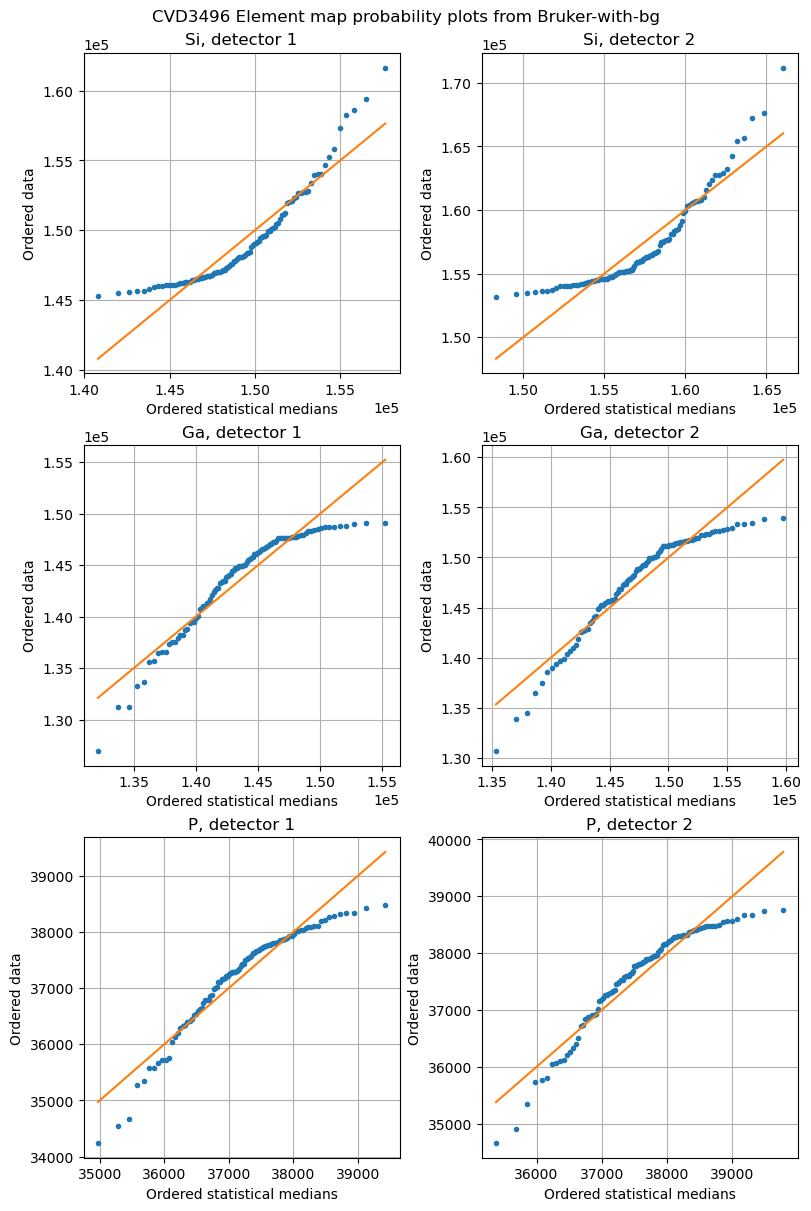

In [12]:
def probPlot(ax, dat, title):
    
    osm, osr = stats.probplot(dat, (np.average(dat), np.std(dat)), dist="norm", fit=False)
    ax.plot(osm, osr, ".") #plot data
    ax.plot(osm, osm, "-") #plot line y=x
    ax.grid(True)
    ax.ticklabel_format(scilimits=(-5,5))
    ax.set_title(title)
    ax.set_xlabel("Ordered statistical medians")
    ax.set_ylabel("Ordered data")

f, ((ax10, ax11), (ax12, ax13), (ax14, ax15)) = plt.subplots(nrows=3, ncols = 2, figsize = (8, 12), layout="constrained")

probPlot(ax10, vec["Si_d1"], "Si, detector 1")
probPlot(ax11, vec["Si_d2"], "Si, detector 2")

probPlot(ax12, vec["Ga_d1"], "Ga, detector 1")
probPlot(ax13, vec["Ga_d2"], "Ga, detector 2")

probPlot(ax14, vec["P_d1"], "P, detector 1")
probPlot(ax15, vec["P_d2"], "P, detector 2")

f.suptitle(sample_name + " Element map probability plots from " + source)

plt.savefig("./" + path_label + "_map/results_out/" + path_label + "_prob_plots_" + source + ".png",
            dpi="figure",
            format="png")

# Heatmap
These cells plot heatmaps of the data.

## Contour map
This cell plots the data with `contourf()`, resulting in a smoothed plot with discrete levels.

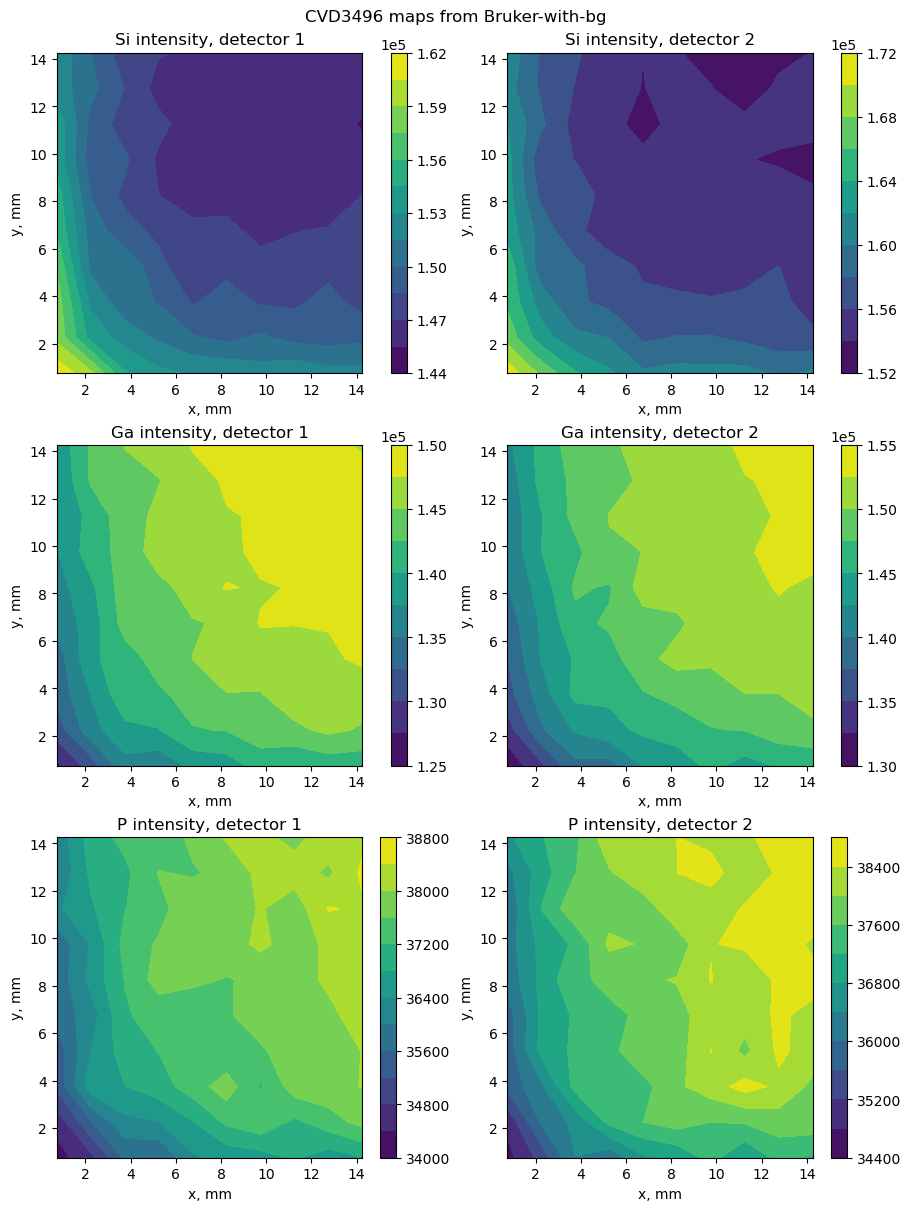

In [17]:
c="viridis" #colormap to use

#cs = {"red": ((0, 0.46, 0.46), (0.5, 0.9, 0.9), (1, 0.86, 0.86)),
#      "green": ((0, 0.57, 0.57), (0.5, 0.88, 0.88), (1, 0.2, 0.2)),
#      "blue": ((0, 0.85, 0.85), (0.5, 0.86, 0.86), (1, 0.53, 0.53))}

#c = colors.LinearSegmentedColormap("b", cs)

l = 10 #how many levels in the contour map

fg, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(9, 12), layout="constrained")

def drawMap(a, dat, cm, levs, title):
    """draw contour plot
    dat is array of data to draw
    a is axes on which to draw it
    cm is the color map to use
    title is the title to write
    """
    im_pointer = a.contourf(dat, levels = levs, extent = [0, grid_dim, 0, grid_dim], cmap=cm, origin = "lower")
    cb = plt.colorbar(im_pointer, ax=a)
    cb.formatter.set_powerlimits((-5,5))
    a.set_title(title)
    a.set_xlabel("x, mm")
    a.set_ylabel("y, mm")

drawMap(ax1, dat["Si_d1"], c, l, "Si intensity, detector 1")
drawMap(ax2, dat["Si_d2"], c, l, "Si intensity, detector 2")

drawMap(ax3, dat["Ga_d1"], c, l, "Ga intensity, detector 1")
drawMap(ax4, dat["Ga_d2"], c, l, "Ga intensity, detector 2")

drawMap(ax5, dat["P_d1"], c, l, "P intensity, detector 1")
drawMap(ax6, dat["P_d2"], c, l, "P intensity, detector 2")

fg.suptitle(sample_name + " maps from " + source)

plt.savefig("./" + path_label + "_map/results_out/" + path_label + "_intensity_contour_map_" + source + ".png",
            dpi="figure",
            format="png")

#for contourf(), [0][0] is displayed in the bottom left, [0][9] is in the bottom right
#for imshow(), [0][0] is displayed in the top left, [0][9] is in the top right

## Pixelated map
This cell plots the data with `imshow()`, resulting in a pixelated plot with a continuous color scale.

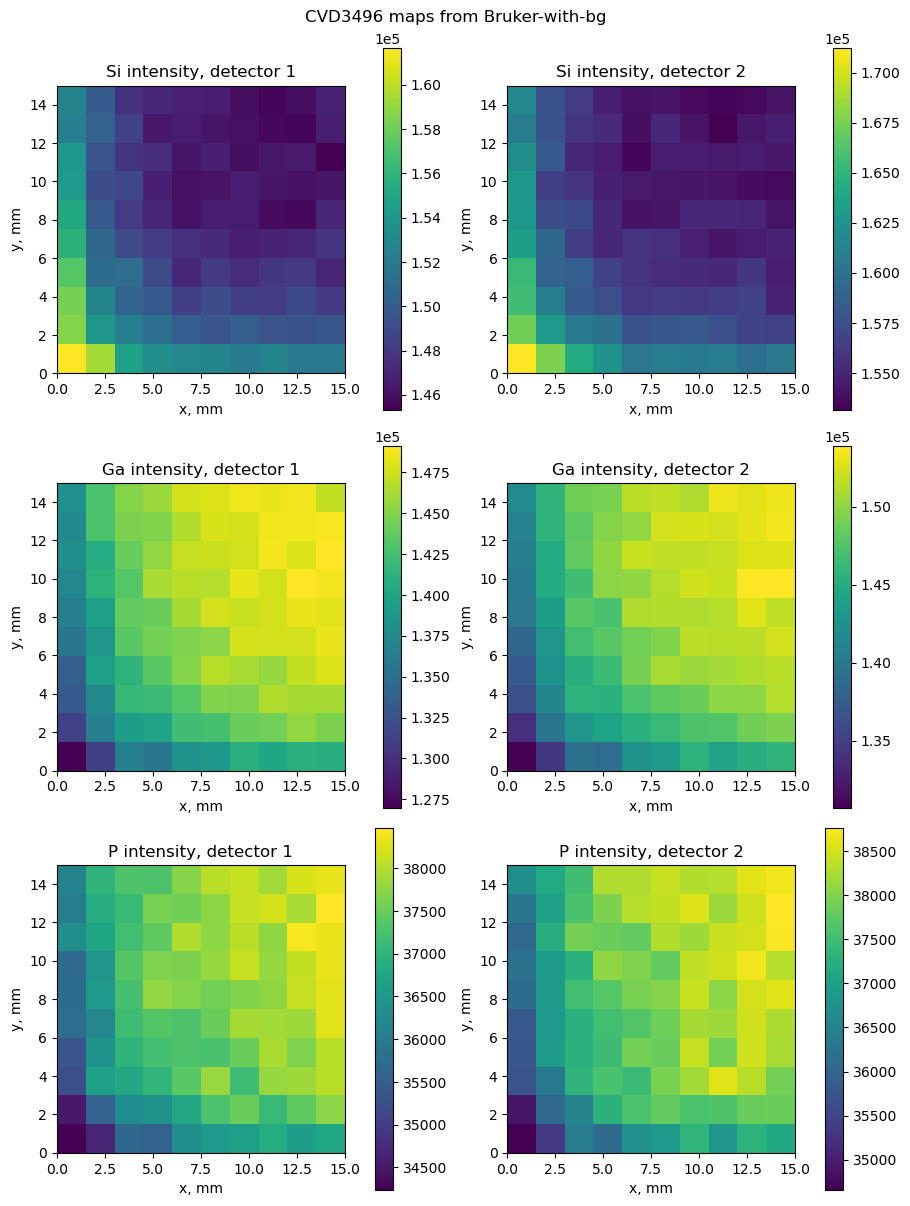

In [14]:
c="viridis"

fg, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(9, 12), layout="constrained")

def drawPix(a, dat, cm, title):
    """draw pixelated heatmap
    dat is array of data to draw
    a is axes on which to draw it
    cm is the color map to use
    title is the title to write
    """
    im_pointer = a.imshow(dat, extent = [0, grid_dim, 0, grid_dim], cmap = cm, origin = "lower")
    cb = plt.colorbar(im_pointer, ax=a)
    cb.formatter.set_powerlimits((-5,5))
    a.set_title(title)
    a.set_xlabel("x, mm")
    a.set_ylabel("y, mm")

drawPix(ax1, dat["Si_d1"], c, "Si intensity, detector 1")
drawPix(ax2, dat["Si_d2"], c, "Si intensity, detector 2")

drawPix(ax3, dat["Ga_d1"], c, "Ga intensity, detector 1")
drawPix(ax4, dat["Ga_d2"], c, "Ga intensity, detector 2")

drawPix(ax5, dat["P_d1"], c, "P intensity, detector 1")
drawPix(ax6, dat["P_d2"], c, "P intensity, detector 2")

fg.suptitle(sample_name + " maps from " + source)

plt.savefig("./" + path_label + "_map/results_out/" + path_label + "_intensity_pixel_map_" + source + ".png",
            dpi="figure",
            format="png")

#for contourf(), [0][0] is displayed in the bottom left, [0][9] is in the bottom right
#for imshow(), [0][0] is displayed in the top left, [0][9] is in the top right

# Plot Si Ka intensity vs. time
this can be useful for assessing the stability of the source intensity

In [15]:
#fortran order: first index changes fastest
#in the data reading cell, y is written to the first index
#the scan proceeds with y changing fastest
#so this matches the order in which the points are collected
vec2 = np.reshape(dat["Si_d1"], 400, order="F")

f, ax = plt.subplots(figsize=(10,4))
ax.plot(vec2)
ax.grid(True)

ax.set_xticks(np.arange(0, 420, 20))
plt.show()

ValueError: cannot reshape array of size 100 into shape (400,)